In [1]:
import json
import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# gensim
from gensim import corpora, models, similarities, matutils
import gensim
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


import preprocessor as p # 
import string # use string.punctuation to clean out punctuation

from pprint import pprint

from datetime import datetime
import pickle

from sklearn.manifold import TSNE

from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)

In [2]:
with open("clean_tweets_sample.pkl", 'rb') as picklefile: 
    sampleDF = pickle.load(picklefile)

In [3]:
with open("clean_tweets_full.pkl", 'rb') as picklefile: 
    fullDF = pickle.load(picklefile)

## Preprocessing

In [4]:
def just_text(tweetsDF):
    cleanDF = pd.DataFrame(columns = ['id','full_text'])
    cleanDF['full_text'] = tweetsDF['full_text']
    cleanDF.drop('id',axis = 1).head()
    return cleanDF

In [5]:
sampletextDF = just_text(sampleDF)

In [6]:
fulltextDF = just_text(fullDF)

# Set Stopwords

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
#stop += ['climate', 'change', 'global', 'warming', 'climatechange', 'globalwarming', 'caroline', 'comes']

## Word2Vec

In [22]:
def make_word2vec(tweetsDF, min_count):
    texts = [[word for word in document.lower().split() if word not in stop]
             for document in tweetsDF.full_text]
    model = gensim.models.Word2Vec(texts, size=100, window=2, min_count=min_count, workers=2,sg=1)
    return model


In [23]:
sample_model = make_word2vec(sampletextDF, 300)

2018-03-06 17:17:01,219 : INFO : collecting all words and their counts
2018-03-06 17:17:01,220 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-06 17:17:01,264 : INFO : PROGRESS: at sentence #10000, processed 143719 words, keeping 7445 word types
2018-03-06 17:17:01,293 : INFO : collected 10197 word types from a corpus of 250874 raw words and 17579 sentences
2018-03-06 17:17:01,296 : INFO : Loading a fresh vocabulary
2018-03-06 17:17:01,303 : INFO : min_count=300 retains 146 unique words (1% of original 10197, drops 10051)
2018-03-06 17:17:01,305 : INFO : min_count=300 leaves 122455 word corpus (48% of original 250874, drops 128419)
2018-03-06 17:17:01,307 : INFO : deleting the raw counts dictionary of 10197 items
2018-03-06 17:17:01,309 : INFO : sample=0.001 downsamples 129 most-common words
2018-03-06 17:17:01,312 : INFO : downsampling leaves estimated 59643 word corpus (48.7% of prior 122455)
2018-03-06 17:17:01,317 : INFO : estimated required memor

In [24]:
full_model = make_word2vec(fulltextDF, 1000)

2018-03-06 17:17:17,506 : INFO : collecting all words and their counts
2018-03-06 17:17:17,507 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-06 17:17:17,549 : INFO : PROGRESS: at sentence #10000, processed 146557 words, keeping 6168 word types
2018-03-06 17:17:17,585 : INFO : PROGRESS: at sentence #20000, processed 289317 words, keeping 7685 word types
2018-03-06 17:17:17,623 : INFO : PROGRESS: at sentence #30000, processed 433360 words, keeping 7708 word types
2018-03-06 17:17:17,666 : INFO : PROGRESS: at sentence #40000, processed 577465 words, keeping 7868 word types
2018-03-06 17:17:17,706 : INFO : PROGRESS: at sentence #50000, processed 724264 words, keeping 7903 word types
2018-03-06 17:17:17,754 : INFO : PROGRESS: at sentence #60000, processed 871995 words, keeping 7906 word types
2018-03-06 17:17:17,794 : INFO : PROGRESS: at sentence #70000, processed 1016149 words, keeping 7907 word types
2018-03-06 17:17:17,831 : INFO : PROGRESS: at senten

# Sample results

In [12]:
model.most_similar('paris' ,topn=8)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2018-03-06 17:11:23,659 : INFO : precomputing L2-norms of word weight vectors


[('despite', 0.8983872532844543),
 ('agreement', 0.8416309952735901),
 ('rise', 0.7220117449760437),
 ('seas', 0.7182766795158386),
 ('say', 0.7028976678848267),
 ('levels', 0.6793060302734375),
 ('effects', 0.6144499778747559),
 ('nothing', 0.597480297088623)]

In [61]:
model.similarity('climate','change')

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5843696307241345

In [62]:
model.similarity('global', 'warming')

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.37933345420453995

In [63]:
model.n_similarity(['global', 'warming'], ['climate', 'change'])

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  """Entry point for launching an IPython kernel.


0.5786720701490679

In [19]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


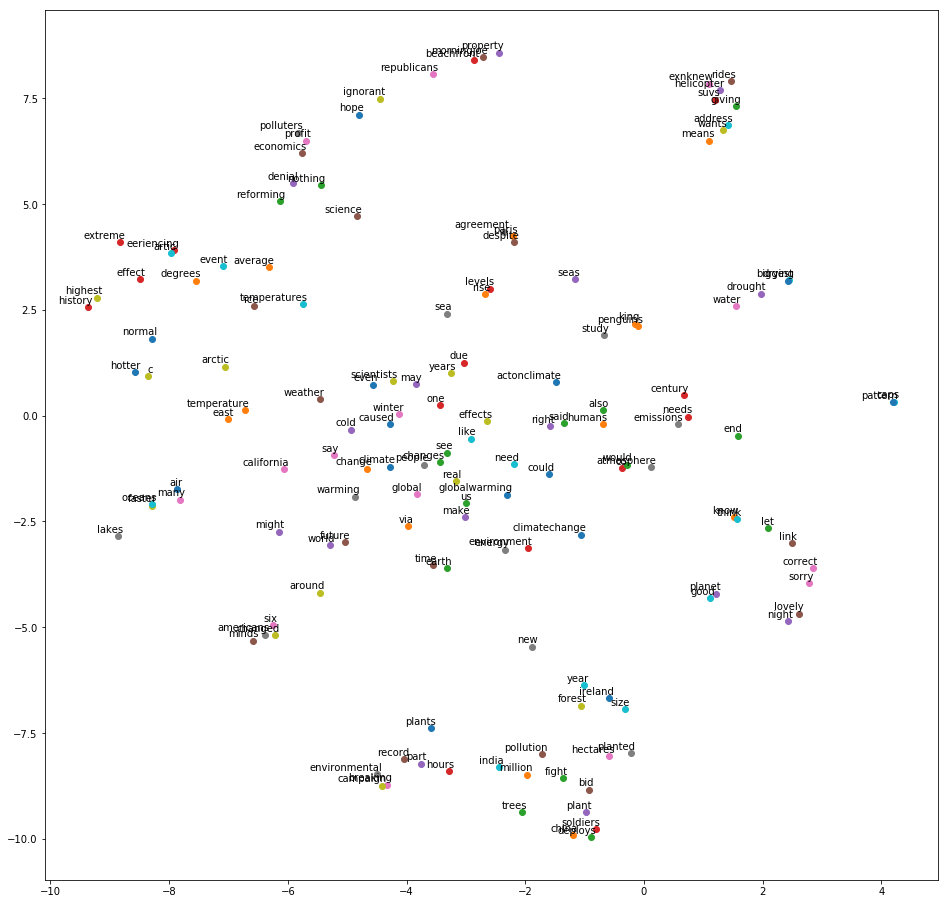

In [20]:
tsne_plot(model)

# Full results

In [15]:
full_model.most_similar('paris' ,topn=8)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2018-03-06 17:13:12,430 : INFO : precomputing L2-norms of word weight vectors


[('agreement', 0.6465603113174438),
 ('meet', 0.500439465045929),
 ('goals', 0.46194374561309814),
 ('metres', 0.4532628357410431),
 ('folks', 0.4518585205078125),
 ('stopkm', 0.44902506470680237),
 ('renewables', 0.4440508186817169),
 ('cut', 0.4408530294895172)]

In [16]:
full_model.similarity('climate','change')

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.4840257498876209

In [17]:
full_model.similarity('global', 'warming')

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5245543249758522

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


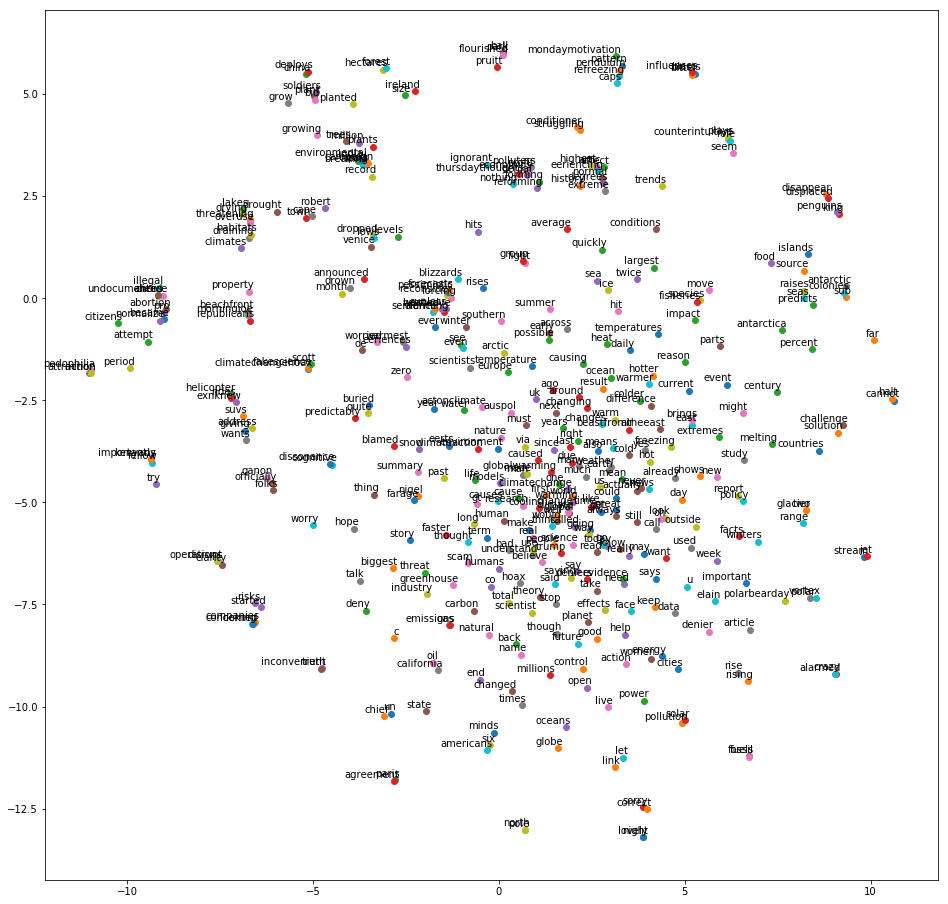

In [25]:
tsne_plot(full_model)